**Instal libraries**

In [1]:
!pip install scanpy
!pip install muon

In [2]:
import scanpy as sc
import muon as mu
import time
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit, fsolve, least_squares


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import math

import statsmodels.api as sm
from statsmodels.formula.api import ols

import sys
from contextlib import contextmanager

**Load data**

In [4]:
def load_data():
    load_start_time = time.time()
    adata = mu.read("Satija.h5mu")
    print("----Data successfully loaded in %d seconds----" % (time.time() - load_start_time))
    return adata


full_data = load_data()


FileNotFoundError: [Errno 2] No such file or directory: 'Satija.h5mu'

**View data**

In [ ]:
with mu.set_options(display_style="html", display_html_expand=0b00000):
    display(full_data)

Source links: '\n'
https://github.com/scverse/muon-tutorials/blob/master/cite-seq/1-CITE-seq-PBMC-5k.ipynb '\n'
https://github.com/scverse/muon-tutorials/blob/master/cite-seq/2-CITE-seq-PBMC-5k-Weighted-Neighbours.ipynb '\n'
https://www.sc-best-practices.org/introduction/analysis_tools.html '\n'
https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html '\n'

**Create histogram**

In [ ]:
adata = full_data['ADT']
#print(adata.var.index == 'CD57')
plt.hist(adata.X[: ,adata.var.index == 'CD57'], bins = 100)


In [ ]:
full_data['ADT'][full_data.obs.donor == 'P1'] ##donor subset

**Tasks**
- divide dataset by people
- divide dataset by cells
 - interesting proteins
 - treshold
     - methods to subset with gausians - proteins - fitting distribution by gaussians  
     - find in article or by the gating paper how to categorize cell gates 

**Gaussians threshold**
 - https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of
 - I have no idea how this works
 - It just does
 - And looks cool

In [ ]:
def plot_gaussians(cell_type):
    data= adata.X[: ,adata.var.index == cell_type]
    y,x,_=plt.hist(data, 100, alpha=.3, label='data')
    x=(x[1:]+x[:-1])/2 
    
    
    def gauss(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/2/sigma**2)
    
    def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    
    expected = (2, .2, 250, 3, .2, 125) ##expected = (1, .2, 250, 2, .2, 125)
    params, cov = curve_fit(bimodal, x, y, expected)
    sigma=np.sqrt(np.diag(cov))
    x_fit = np.linspace(x.min(), x.max(), 500)
    
    plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
    
    plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
    plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
    
    plt.legend()
    print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
    plt.show() 

plot_gaussians("CD57") ##-- pretty example
##plot_gaussians(adata.var.index.to_numpy()[3]) ##-- pretty example
##plot_gaussians(adata.var.index.to_numpy()[1]) ##-- not working example
##plot_gaussians(adata.var.index.to_numpy()[5]) ##-- crashing example
##plot_gaussians(adata.var.index.to_numpy()[7]) ##-- crashing example

**?Possible fix?**
- Increase maxfev
  - I have no idea what this is but the curves look ugly after this (but at least no crashes)
- Play with the "exprected" parameter
  - Initialy was set to "expected = (1, .2, 250, 2, .2, 125)" the first and fourth influence the position where we look for the gaussians
  - Maybe calculate somehow the first and fourth value
- Actually try to understand the code
  - Some of the topics that the people on StackOverflow discuss sound like magic to me


**Notes** 

Find positive 
- 1. find intersect of two gaussians
- 2. false discovery rate

Find cells that are interesting (Paper) - > Confirm which are actualy those type (Histogram)
- Paper bar plot 
- Paper attachment - cell types

  
  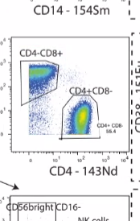

T lymphocyte
  - CD4 -
  - CD8 +
  - CD4 - <-> CD8 +

T effector
  - CD45RA +
  - CCR7 -

T effector memory
  - CD45RA -
  - CCR7 -

Treg cells
  - CD3, CD4, CD25 +
  - CD127 -

Monocytes
  - CD14 +
  - CD33 +

NK
  - CD3 -
  - CD16 +

Th2 non-TFH
  - ???

Central memory
  - CD45RA -
  - CCR7 - 
 
Lymphocytes
  - CD14 -  | -- Conditions FOR ALL lymphocytes
  - CD33 -  |
 
Plasmablasts
  - CD3 -
  - CD20 -
  - C27 +
  - CD38 +

T naive cells
  - CD45RA +
  - CCR7 - 
  
  


**Tasks** 

- figure out the thresholding
- count the cell types with each donor
  - threshold
  - sub set
  - count
  - 8 individuals
  - for each 30 barplots = smart visualization
- how do they count the frequencies = for now divide the cell counts by all cells

Other factors 
 - CNV virus
 - gender
 - dataset bias


scikitlear 
scipy

Gaussian clustering - Gaussian mixture model 

 

**Ploting thresholds**

In [ ]:
expected_dictionary = {"CD57" : (2, .1, 250, 3, .1, 125),
                           "CD14" : (0.5, .1, 250, 1.7, .1, 125),
                           "CD4-1" : (2, .1, 250, 5, .1, 125),
#                           "CD4-2" : (0.5, .1, 250, 1.5, .1, 125),
                           "CD8": (0.5, .1, 250, 3.5, .1, 125),
                           "CD45RA" : (0.5, .1, 250, 1.8, .1, 125),
                           "CD3-1" : (0.7, .1, 250, 2.7, .1, 125),
                           "CD3-2" : (0.7, .1, 250, 3, .1, 125),
#                           "CD25" : (0.5, .1, 250, 1, .1, 125),
                           "CD127" : (0.6, .1, 250, 2, .1, 125),
#                           "CD33" : (2, .1, 250, 3, .1, 125),
                           "CD16" : (1, .1, 250, 3, .1, 125),
#                           "CD20" : (0, .1, 250, 0.4, .1, 125),
#                           "CD38-1" : (0, .1, 2500, 4, .1, 125),
#                           "CD38-2" : (0, .1, 2500, 4, .1, 125),
                           "CD161" : (0, .1, 250, 1.2, .1, 125),
                           "CD27" : (0.5, .1, 250, 3, .1, 125),
                           "CD28" : (1, .1, 250, 2.1, .1, 125),
#                           "CD185" : (2, .1, 250, 3, .1, 125), CXCR5
#                           "CD183" : (2, .1, 250, 3, .1, 125), CXCR3
#                           "CD196" : (2, .1, 250, 3, .1, 125),##CCR6
                      }
manual_histograms = ["CD4-2", "CD20", "CD38-1", "CD38-2", "CD185", "HLA-DR", "CD19", "CD28", "CD25", "CD196", "CD185"]
missing_data = ["CD33", "CD183"]

In [ ]:
def draw_histograms_manual(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize = (12,12))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        data = adata.X[: ,adata.var.index == var_name]
        y,x,_ = ax.hist(data, bins = 100, alpha = .3)
        ax.set_title(var_name)

    fig.tight_layout()    
    plt.show()


In [ ]:
def gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / 2 / sigma**2)
    
def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1) + gauss(x, mu2, sigma2, A2)

def find_intersections(gauss1_params, gauss2_params, x_range):
    mu1, sigma1, A1 = gauss1_params
    mu2, sigma2, A2 = gauss2_params

    def difference(x):
        return gauss(x, mu1, sigma1, A1) - gauss(x, mu2, sigma2, A2)

    x_initial_guesses = np.linspace(x_range[0], x_range[1], 500)
    intersections = []

    for x0 in x_initial_guesses:
        root, info, ier, msg = fsolve(difference, x0, full_output=True)
        if ier == 1 and x_range[0] <= root <= x_range[1]:
            intersections.append(root[0])
    
    intersections = np.unique(intersections)
    return intersections

def draw_histograms(df, variables, n_rows, n_cols):
    intersection_dict = {}
    fig = plt.figure(figsize=(12,12))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        data = adata.X[:, adata.var.index == var_name]
        if data.size == 0:
            print(var_name + " is empty\n")
            continue
        y, x, _ = ax.hist(data, bins=100, alpha=.3)
        x = (x[1:] + x[:-1]) / 2 
    
        expected = expected_dictionary[var_name]  # expected = (1, .2, 250, 2, .2, 125)
        try:
            params, cov = curve_fit(bimodal, x, y, expected)
        except RuntimeError:
            print(var_name)
            continue
        sigma = np.sqrt(np.diag(cov))
        x_fit = np.linspace(x.min(), x.max(), 500)
    
        ax.plot(x_fit, bimodal(x_fit, *params), color='red', lw=0)
    
        ax.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--")
        ax.plot(x_fit, gauss(x_fit, *params[3:]), color='green', lw=1, ls=":")
        
        intersections = find_intersections(params[:3], params[3:], (x.min(), x.max()))
        
        for x_int in intersections:
            ax.axvline(x=x_int, color='blue', linestyle='--', lw=1)
        
        intersection_dict[var_name] = intersections
        
        ax.set_title(var_name)

    
    fig.tight_layout()
    plt.show()
    return intersection_dict


PROTEIN FEEDBACK

Čo sa týka chýbajúcich proteínov: 
1. Pre CD3, CD4 a CD38 v projekte použili dve rôzne protilátky. Keď si dáte vypísať všetky názvy riadkov, tak uvidíte, že tam je napr. CD3-1 a CD3-2. To sa niekedy robí, aby sa znížilo nešpecifické viazanie protilátky. Pre obidve verzie by mali zhruba tie isté bunky byť pozitívne - spravte 2D histogram (alebo 2D density plot) CD3-1 vs CD3-2, aby sme si to vizuálne overili. Ako CD3 pozitívne môžeme potom brať tie, ktoré sú pozitívne pre obe verzie protilátky. Podobne pre CD4 a CD38.
2. CD85j v dátach chýba, je tam len CD85g - subset buniek, pre ktorý potrebujeme CD85j, budeme musieť vyškrtnúť z analýzy
3. CCR7 chýba tiež, avšak keby sme vyškrtli všetky subsety s CCR7, tak nám ich zostane pomerne málo. Namiesto CCR7 sa dá pomerne dobre použiť CD27 alebo CD28. Nie je to dokonalé, ale musíme pracovať s tým, čo máme. Spravte prosím obidve verzie (teda jednu takú, kde miesto CCR7 používame CD27, jednu takú, kde namiesto CCR7 používame CD28).
4. Vo Vašom zozname ešte asi chýbajú nejaké proteíny, napr. CXCR5 alebo CCR6 (tieto majú aj svoje označenia začínajúce CD, vygooglite si na wikipedii). Pozrite si znova Fig. 3a v tom Nature Medicine článku, aby sme vedeli čím viac z tých subsetov kvantifikovať.

Skúste prosím následne spraviť barplot s frekvenciami všetkých relevantných subsetov pre každého donora zvlášť.

Ak budete mať otázky, píšte mi možno na whatsapp, 0940641163. Na mejly mi tieto dni trvá dlhšie odpovedať a nechcem, aby ste sa zdržiavali kvôli mne. 

Martin

In [ ]:
intersection = draw_histograms(adata, expected_dictionary.keys(), math.ceil(len(expected_dictionary)/2), 2)

In [ ]:
draw_histograms_manual(adata, manual_histograms, math.ceil(len(manual_histograms)/2), 2)

**Creating cell marker definitions**

In [ ]:
manual_intersection = {
    "HLA-DR": 1.7,
    "CD185": 0.6, 
    "CD38-2": 2.1,
    "CD38-1": 2.6,
    "CD20": 0.8,
    "CD4-2": 1.1,
    "CD19": 3,
    "CD28": 1.6,
    "CD25": 1.0,
    "CD196": 1.7,
    "CD185": 0.8
}

In [ ]:
cell_type_dict = {
    "T": ["CD3-1 +", "CD3-2 +", "CD14 -"],
    "Effector": ["CD45RA +", "CCR7 -"],
    "Treg_cells": ["CD3-1 +", "CD3-2 +","CD4-1 +", "CD4-2 +","CD25 +","CD127 +"],
    "Monocytes": ["CD14 +","CD33 +"],
    "NK": ["CD3-1 -", "CD3-2 -","CD16 +"],
    "Central_memory": ["CD45RA -", "CCR7 +"],
    "Effector_memory": ["CD45RA -", "CCR7 -"],
    "Lymphocytes": ["CD14 -","CD33 -"],
    "Plasmablast": ["CD3-1 -", "CD3-2 -","CD20 -","CD27 +","CD38-1 +", "CD38-2 -"],
    "Naive": ["CD45RA +", "CCR7 +"],
    "B": ["CD20 +", "CD19 +"]   
}

In [ ]:
CELLS = [
    "CD57 + CD8 + T",
    "Effector CD8 + T",
    "CD28 - CD8 + T",
    "Effector_memory CD8 + T",
    "Treg_cells",
    "Effector_memory CD4-1 + CD4-2 + T",
    "Monocytes",
    "NK",
    "CD57 + NK",
    "Central_memory CD4-1 + CD4-2 + T",
    "HLA-DR - CD38-1 + CD38-2 + CD4-1 + CD4-2 + T",
    "T",
    "Lymphocytes",
    "CD161 + NK",
    "CD8 + T",
    "Plasmablast",
    "Naive CD4-1 + CD4-2 + T",
    "B",
    "CD27 + CD8 + T",
    "CD161 - CD45RA + CD4-1 + CD4-2 + Treg_cells",
    "CD185 + CD4-1 + CD4-2 + T",
    "Naive CD8 + T"

#    "CD94 + NK",
#    "CXCR5 + CD8 + T",
#    "Th17 CXCR5–CD4+ T",
#    "Th1 TFH CD4 + T", 
#    "CXCR3–CCR6+CXCR5+CD8+ T",
#    "Th1 non-TFH CD4 + T",
#    "Th2 TFH CD4+ T",
#    "CXCR3 - CCR6 - CXCR5 + CD8 + T",
#    "Th2 non-TFH CD4 + T",
#    "PD1 + CD8 + T",   
]

**Counting cells with markers**

In [ ]:
def cell_into_markers(cells):
    markers = {}
    for cell in cells:
        res = ""
        args = cell.split()
        for arg in args:
            if arg in cell_type_dict:
                res += " ".join(cell_type_dict[arg]) + " "
            else:
                res += arg
                if arg != args[-1]:
                    res += " "
        markers[cell] = res
    return markers


In [ ]:
markers = cell_into_markers(CELLS)
for cell, marker in markers.items():
    total_width = 79
    cell_len = len(cell)
    buffer_size = total_width - cell_len
    
    left_buffer_size = buffer_size // 2
    right_buffer_size = buffer_size - left_buffer_size
    
    print("-" * left_buffer_size + cell + "-" * right_buffer_size)
    print(marker, "\n")


In [ ]:
def count_rows_with_multiple_conditions(adata, conditions, CCR7_replacement = "CCR7"):
    mask = np.ones(adata.shape[0], dtype=bool)
    args = conditions.split()
    
    for i in range(len(args)):
        column_name = args[i]
        
        if column_name in ["+", "-"]:
            continue
        if i == len(args) - 1:
            break
        if column_name == "CCR7" and CCR7_replacement != "CCR7":
            column_name = CCR7_replacement
            
        if column_name not in adata.var_names:
            print("MARKER NOT FOUND:", column_name)
            raise ValueError(f"Column '{column_name}' not found in adata.var_names")

        operator = args[i + 1]
        column_index = adata.var_names.get_loc(column_name)
        try:
            value = intersection[column_name][0]
            if column_name == "CD25":
                value = intersection[column_name][1]
            
        except KeyError:
            value = manual_intersection[column_name]

        column_data = adata.X[:, column_index]
        

        if operator == "+":
            mask &= (column_data > value)
        elif operator == "-":
            mask &= (column_data < value)
        

    
    count = np.sum(mask)
    
    return count

In [ ]:
def print_counts(markers, adata):
    for cell, marker in markers.items():
        try:
            res = count_rows_with_multiple_conditions(adata, marker, "CD27")
            print("Success at cell type:", cell, "\nWith markers:", marker, "\nCount:", res)  
        except:
            print("Failed at cell type:", cell, "\nWith markers:", marker)
        print("\n")
print_counts(markers, adata)

In [ ]:
print_counts(markers ,full_data['ADT'][full_data.obs.donor == 'P1'])

**Cell frequencies in donors histograms**

In [ ]:
donors = sorted(list({x for x in full_data.obs.donor}))

In [ ]:
def get_counts(markers, adata):
    counts_dict = {}
    for cell, marker in markers.items():
        try:
            count = count_rows_with_multiple_conditions(adata, marker, "CD27")
            counts_dict[cell] = count
        except:
            print("Failed at cell type:", cell, "\nWith markers:", marker, "\n")
    return counts_dict
        
def plot_donor_cells_histogram(donors, n_rows, n_cols):
    fig = plt.figure(figsize = (12,30))
    max_y = 0
    for i, donor in enumerate(donors):
        print("----", donor, "-----")
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        counts_dict = get_counts(markers, adata[full_data.obs.donor == donor])
        total_donor_count = adata[full_data.obs.donor == "P1"].n_obs
        
        ax.bar(counts_dict.keys(), [x / total_donor_count for x in counts_dict.values()], color='g')
        ax.set_title(donor)

        ax.set_xticks(range(len(counts_dict)))
        ax.set_xticklabels(counts_dict.keys(), rotation=90, ha='right')

        ax.set_ylim(0, 1)

        
    plt.tight_layout(pad=6.0)
    plt.show()

In [ ]:
plot_donor_cells_histogram(donors, 4, 2)

In [ ]:
def return_rows_with_multiple_conditions(adata, conditions, donor, CCR7_replacement = "CCR7"):
    donor_subset = adata[full_data.obs.donor == donor]
    mask = np.ones(donor_subset.shape[0], dtype=bool)
    args = conditions.split()

    for i in range(len(args)):
        column_name = args[i]
        
        if column_name in ["+", "-"]:
            continue
        if i == len(args) - 1:
            break
        if column_name == "CCR7" and CCR7_replacement != "CCR7":
            column_name = CCR7_replacement
            
        if column_name not in adata.var_names:
            print("MARKER NOT FOUND:", column_name)
            raise ValueError(f"Column '{column_name}' not found in adata.var_names")

        operator = args[i + 1]
        column_index = adata.var_names.get_loc(column_name)
        try:
            value = intersection[column_name][0]
            if column_name == "CD25":
                value = intersection[column_name][1]
            
        except KeyError:
            value = manual_intersection[column_name]

        column_data = donor_subset.X[:, column_index]

        if operator == "+":
            mask &= (column_data > value)
        elif operator == "-":
            mask &= (column_data < value)
    cell_donor_subset = donor_subset[mask]

        
    return cell_donor_subset

**Loading metadata of donors**

In [ ]:
metadata_df = pd.read_excel("mmc3.xlsx")
metadata_df.set_index("Donor", inplace=True)

**Creating swarmplots for donor frequencies in cells**

In [ ]:
def swarm_plot():
    counts_per_donor = {donor: {} for donor in donors}
    
    for donor in donors:
        counts_dict = get_counts(markers, adata[full_data.obs.donor == donor])
        total_donor_count = adata[full_data.obs.donor == donor].n_obs
        
        for cell_type, count in counts_dict.items():
            counts_per_donor[donor][cell_type] = count / total_donor_count

    df = pd.DataFrame.from_dict(counts_per_donor, orient='index')
    df_melted = df.reset_index().melt(id_vars='index', var_name='Cell_Type', value_name='Count')
    df_melted.rename(columns={'index': 'Donor'}, inplace=True)
    
    plt.figure(figsize=(12, 8))
    sns.swarmplot(data=df_melted, x='Cell_Type', y='Count', hue='Donor', palette='Set2')
    plt.title('Swarm Plot of Immune Cell Counts per Donor')
    plt.ylabel('Count freqency')
    plt.legend(title='Donor')
    plt.xticks(rotation=45, ha='right')
    plt.show()    
    return df_melted


In [ ]:
counts_long_df = swarm_plot()

In [ ]:
counts_long_df["CMV_positive"] = counts_long_df["Donor"].apply(lambda x: True if metadata_df.loc[x].CMV == "positive" else False)
counts_long_df["Gender"] = counts_long_df["Donor"].apply(lambda x: "Male"  if metadata_df.loc[x].Gender == "M" else "Female")
counts_long_df["Treatment"] = counts_long_df["Donor"].apply(lambda x: metadata_df.loc[x].Treatment)

In [ ]:
counts_long_df

**Conducting ANOVA to see if any of the variables influence the frequencies**

In [ ]:
counts_long_df[counts_long_df['Cell_Type'] == 'CD57 + CD8 + T'].iloc[:, [2,5]]
##z tohoto potom spravis funkciu ktora dostane ktory parameter berieme ako premenny a spravi ANOVU 
##pre vsetky bunky
def anova_get_p_value(data):
    cell_types = set(counts_long_df.iloc[: , 1])
    anova_var = {'Gender', 'Treatment', 'CMV_positive'}
    anova_to_p_vals_dict = {}
    p_vals = {}
    
    for column in anova_var:
        print("Now running anova for:", column, "\n")
        
        for cell_type in cell_types:
            curr_data = data[data['Cell_Type'] == cell_type]
            formula = f'Count ~ C({column})'
            model = ols(formula, data=curr_data).fit()
            anova_results = sm.stats.anova_lm(model, typ=2)

            p_value = anova_results["PR(>F)"][f"C({column})"]
            if p_value <= 0.05:
                print("Null hypothesis rejected with cell type:", cell_type, "and p value:", str(round(p_value, 5)))
            p_vals[cell_type] = p_value
            
        print("\nFinished running anova for:", column, "\n")
        
        anova_to_p_vals_dict[column] = p_vals
        p_vals = {}
    return anova_to_p_vals_dict
    



In [ ]:
anova_vals = anova_get_p_value(counts_long_df)

In [ ]:
@contextmanager
def redirect_stdout(to):
    original_stdout = sys.stdout
    sys.stdout = to
    try:
        yield
    finally:
        sys.stdout = original_stdout


with open('anova_res.txt', 'w') as f:
    with redirect_stdout(f):
        anova_vals = anova_get_p_value(counts_long_df)

with open('anova_res_separate.txt', 'w') as f:
    with redirect_stdout(f):
        anova_vals = anova_get_p_value(counts_long_df, True)